<a href="https://colab.research.google.com/github/finlaycm/tensorflow_tumor_detection/blob/master/part4_newslide_preparation_for_evaluation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
colab_root_dir = '/content'
drive_dir='/content/drive'
project_root_dir = os.path.join(drive_dir,'My Drive','deeplearning','cancer_classification')
eval_dir = os.path.join(project_root_dir,'eval')
patch_folder = os.path.join(colab_root_dir,'patches_to_eval')
os.makedirs(patch_folder, exist_ok = True)
drive.mount(drive_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [ ]:
#Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.0.0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2 as cv
import json
from google.colab import drive
import pathlib
import shutil
import random
import time 

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

print(tf.__version__)

import xml.etree.ElementTree as et 


2.0.0


# Prepare new slide for evaluation


1.   Read a slide level 7
2.   get 300 * 300 patches and determine level of gray
3.   for each patch with tissues, extract patches of 300X300 at level 0 




In [ ]:
test_slides = ['tumor_094','tumor_096','tumor_019','tumor_016','tumor_031','tumor_084']

slide_dir=os.path.join(project_root_dir,'myslides')
slide_files = [os.path.join(slide_dir,s) for s in os.listdir(slide_dir) if pathlib.Path(s).stem in test_slides ]
mask_dir=os.path.join(project_root_dir,'mymasks')
mask_files = [os.path.join(mask_dir,m) for m in os.listdir(mask_dir) if pathlib.Path(m).stem.replace('_mask','') in test_slides ]
xml_dir=os.path.join(project_root_dir,'myannotations')
xml_files = [os.path.join(xml_dir,x) for x in os.listdir(xml_dir) if pathlib.Path(x).stem in test_slides ]

test_slides = ['tumor_094','tumor_096','tumor_019','tumor_016','tumor_031','tumor_084']
slide_files

['/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_031.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_019.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_096.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_094.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_084.tif',
 '/content/drive/My Drive/deeplearning/cancer_classification/myslides/tumor_016.tif']

In [ ]:
def read_slide(slide_path, level, x = 0, y = 0, width=None, height=None, as_float=False, show=False):
    slide = open_slide(slide_path)
    if not width: width=slide.level_dimensions[level][0]
    if not height: height=slide.level_dimensions[level][1]
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    if '_mask.tif' in str(slide_path):
      im = im[:,:,0]
    if show:
      plt.imshow(im)
      plt.show()
    return im
def image_preprocess(img):
  x = Image.fromarray(img)
  size = 256,256
  x.thumbnail(size)
  x = np.asarray(x)
  return x
def low_tissue_area(image, intensity=0.8, threshold=0.1):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percent_tissue = len(tissue_pixels) * 100/ float(image.shape[0] * image.shape[1]) 
    if percent_tissue >= threshold:
      return 1
    else: 
      return 0

def show_patches_location_next_to_image(slide_name):
  level = 7
  slide_path = os.path.join(slide_dir,slide_name+'.tif')
  slide = open_slide(slide_path)
  width = slide.level_dimensions[level][0]
  height = slide.level_dimensions[level][1]
  dim = (height,width)
  print(slide.level_dimensions[level])
  pat = np.zeros(dim)
  total_patches_extracted = len(path_locators_level)
  pos_idx = [i for i in range(total_patches_extracted)]
  for i in pos_idx:
    x,y,w,h = np.array(patch_locators_in[i])//2**level
    pat[y:y+h,x:x+w] = 1
  img = read_slide(slide_path,7)
  fig, axs = plt.subplots(ncols=2,nrows=1, figsize=(15,5))

  axs[0].imshow(img)
  axs[1].imshow(pat)
  axs[0].axis('off')
  axs[1].axis('off')

def read_patches_from_region(slide, slide_name, patch_folder, x_orig, y_orig , pwidth, pheight ,level):
  ##starting at level 7, extract 256X256 images and determine if it
  ##has tissues or not. record tissues with tissues to break down at the 
  ## zoom level and disgregard regions with no tissues. When level 0 is reached, 
  ## save coorninates of patch in patch_locators list and save img as numpy array in 
  ##list patches
  global p , patch_locators
  width, height = slide.level_dimensions[level]
  for x in range(x_orig,x_orig+pwidth,256):
    for y in range(y_orig,y_orig+pheight,256):
      w = min(width - x, 256)
      h = min(height - y, 256)
      im = slide.read_region((x*2**level,y*2**level), level, (w, h))
      im = im.convert('RGB')
      im = np.asarray(im)
      contains_tissues = low_tissue_area(im, intensity=0.8, threshold=50/(level+1))
      if contains_tissues == 1:
        regions[level].append((x,y,w,h))
        if level == 0: 
          if p ==0:print('\nPatches extracted so far :',end='')
          if (p + 1) % 1000 == 0:print(p,end=',')
          if (p + 1) % 10000 == 0:print('\n',end='')
          patch_locators.append((x,y,w,h))
          p +=1
  return regions, patch_locators
def save_n_patch_imges(slide_name,n):
  slide_path = os.path.join(slide_dir,slide_name+'.tif')
  slide = open_slide(slide_path)
  total_patches = patch_locators_in.shape[0]
  print('Processiong slide: {} with {} patches: '.format(slide_name,total_patches))

  slide_patch_dir = os.path.join(patch_folder,slide_name)
  groups = [(g,g+n) for g in range(0,total_patches,n)]
  for gl,gu in groups:
    group_folder = os.path.join(slide_patch_dir,'{}-{}'.format(gl,gu-1))
    os.makedirs(group_folder,exist_ok=True)
    print(group_folder,end=',')
    for i,p in enumerate(patch_locators_in[gl:gu]):
      x,y,w,h = p
      level = 0
      patch_path = os.path.join(group_folder,'patch_'+slide_name+'_{}.jpg'.format(i+gl))
      im = slide.read_region((x,y), level, (w, h))
      im = im.convert('RGB')
      im = np.asarray(im)
      Image.fromarray(im).save(patch_path) 
    print(len(os.listdir(group_folder)))
def save_patches(slide_name):
  slide_path = os.path.join(slide_dir,slide_name+'.tif')
  slide = open_slide(slide_path)
  total_patches = patch_locators_in.shape[0]
  print('Processiong slide: {} with {} patches: '.format(slide_name,total_patches))
  slide_patch_dir = os.path.join(colab_root_dir,'patches_'+slide_name)
  os.makedirs(slide_patch_dir,exist_ok=True)
  for i,p in enumerate(patch_locators_in):
      x,y,w,h = p
      level = 0
      patch_path = os.path.join(slide_patch_dir,'patch_'+slide_name+'_{}.jpg'.format(i))
      im = slide.read_region((x,y), level, (w, h))
      im = im.convert('RGB')
      im = np.asarray(im)
      Image.fromarray(im).save(patch_path)
      if i ==0:print('\nPatches extracted so far :',end='')
      if (i + 1) % 1000 == 0:print(i,end=',')
      if (i + 1) % 10000 == 0:print('\n',end='')
  shutil.make_archive('patches_'+slide_name, 'zip', slide_patch_dir)
  shutil.copy('patches_'+slide_name+'.zip',eval_slide_dir)
def extract_tissue_patches(slide_name):
  slide_patch_folder = os.path.join(patch_folder,slide_name)
  os.makedirs(os.path.join(patch_folder,slide_name), exist_ok = True)
  slide_path = os.path.join(slide_dir,slide_name+'.tif')
  img = read_slide(slide_path,7, show = True)
  global patch_locators, level, regions, p
  levels = [i for i in range(6,-1,-1)]
  regions = {i:[] for i in range(8)}
  slide = open_slide(slide_path)   
  ## FIRST RUN at level 7
  level = 7
  width, height = slide.level_dimensions[level]
  regions, patch_locators = read_patches_from_region(slide, slide_name, slide_patch_folder, 0, 0 , width, height ,level)
  start_time = time.time()
  now = time.strftime("%H:%M", time.localtime(start_time))
  print("Start Time {} ".format(now)) 
  for level in levels:
    print('Level {} , Previous level total regions: {}'.format(level, len(regions[level+1])))
    for r in regions[level+1]:
      x_orig, y_orig , pwidth, pheight = r
      reg, path_locators_level0= read_patches_from_region(slide, slide_name, slide_patch_folder, x_orig*2, y_orig*2 , pwidth*2, pheight*2 ,level)
  end_time = time.time()
  now = time.strftime("%H:%M", time.localtime(end_time))
  print("End Time {} ".format(now)) 
  print("--- %s seconds ---" % (end_time - start_time))
  return path_locators_level0

In [ ]:
test_slides

['tumor_094', 'tumor_096', 'tumor_019', 'tumor_016', 'tumor_031', 'tumor_084']

tumor_094


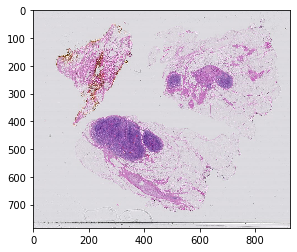

Start Time 05:18 
Level 6 , Previous level total regions: 12
Level 5 , Previous level total regions: 29
Level 4 , Previous level total regions: 87
Level 3 , Previous level total regions: 271
Level 2 , Previous level total regions: 921
Level 1 , Previous level total regions: 2842
Level 0 , Previous level total regions: 8344

Patches extracted so far :999,1999,2999,3999,4999,5999,6999,7999,8999,9999,
10999,11999,12999,13999,14999,15999,16999,17999,18999,19999,
20999,21999,22999,End Time 05:45 
--- 1605.457767009735 seconds ---
(928, 784)
Processiong slide: tumor_094 with 23037 patches: 

Patches extracted so far :999,1999,2999,3999,4999,5999,6999,7999,8999,9999,
10999,11999,12999,13999,14999,15999,16999,17999,18999,19999,
20999,21999,22999,

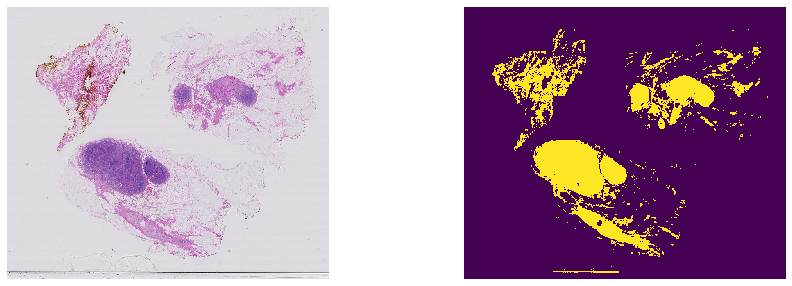

In [ ]:


for slide_name in test_slides[:1]:
  print(slide_name)
  global p , patch_locators
  p = 0
  patch_locators = []
  path_locators_level =  extract_tissue_patches(slide_name)
  eval_slide_dir = os.path.join(project_root_dir,'eval',slide_name)
  os.makedirs(eval_slide_dir, exist_ok = True)
  patch_locators_name = 'patches_'+slide_name+'_locators'
  patch_locators_path = os.path.join(eval_slide_dir,patch_locators_name+'.npy')
  np.save(patch_locators_name, path_locators_level)
  shutil.copy(patch_locators_name+'.npy',eval_slide_dir)
  patch_locators_in = np.load(patch_locators_path)
  show_patches_location_next_to_image(slide_name)
  save_patches(slide_name)